Learnt from: https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/ and Tensoflow official tutorial on DCGAN

# Content
* Conditional DCGAN on MNIST Fashion Dataset

Framework: Tensorflow 2.1

## Import Libraries and Constants

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models

from pathlib import Path    # for saving purpose

BUFFER_SIZE = 59904
HALF_BATCH_SIZE = 128
BATCH_SIZE = 256

# Conditional DCGAN on MNIST Fashion Dataset
## Load Dataset

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Ignore the batch with batch size less than 256
images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')[:BUFFER_SIZE]
images = (images - 127.5) / 127.5

labels = tf.reshape(train_labels, (-1, 1))[:BUFFER_SIZE]

fashion_dataset = tf.data.Dataset.from_tensor_slices((images, labels)).shuffle(BUFFER_SIZE).batch(HALF_BATCH_SIZE)

## Define Discriminator and Generator
The structure of these two models were from the link above.

In [3]:
def define_discriminator(image_shape=(28,28,1), n_classes=10):
	# pass input image
	input_image = layers.Input(shape = image_shape)

	# pass input label, transfer it into a (28, 28, 1) square
	input_label = layers.Input(shape = (1,))
	embedded_label = layers.Embedding(n_classes, 50)(input_label)
	n_nodes = image_shape[0] * image_shape[1]    # (28 * 28) = 784
	fc_label = layers.Dense(n_nodes)(embedded_label)
	square_label = layers.Reshape((image_shape[0], image_shape[1], 1))(fc_label)    # Reshape to (28, 28, 1)


	# combine the (28, 28, 1) image with the (28, 28, 1) label's matrix
	merge = layers.Concatenate()([input_image, square_label])
	# downsample
	fe = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = layers.LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = layers.LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = layers.Flatten()(fe)
	fe = layers.Dropout(0.4)(fe)
	# output
	out_layer = layers.Dense(1, activation='sigmoid')(fe)

	# define model
	model = models.Model([input_image, input_label], out_layer)

	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

	return model

Do not add BN layer to the generator if you are using tensorflow 2.0 or 2.1, it seems to have some bugs.

In [4]:
def define_generator(latent_dim, n_classes=10):
	# Handle input latent, transfer it into a (7, 7, 128) square
	input_latent = layers.Input(shape = (latent_dim,))
	n_nodes = 128 * 7 * 7
	gen = layers.Dense(n_nodes)(input_latent)
	gen = layers.LeakyReLU(alpha=0.2)(gen)
	gen = layers.Reshape((7, 7, 128))(gen)

	# Handle input label, transfer it into a (7, 7, 1) square
	input_label = layers.Input(shape=(1,))
	embedded_label = layers.Embedding(n_classes, 50)(input_label)
	n_nodes = 7 * 7
	fc_label = layers.Dense(n_nodes)(embedded_label)
	square_label = layers.Reshape((7, 7, 1))(fc_label)


	# merge image gen and label input, the new dimention is (7, 7, 129)
	merge = layers.Concatenate()([gen, square_label])
	# upsample to 14x14
	gen = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = layers.LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = layers.LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = layers.Conv2D(1, (7,7), activation='tanh', padding='same')(gen)

	# define model
	model = models.Model([input_latent, input_label], out_layer)
	return model

Test if the two model work well.

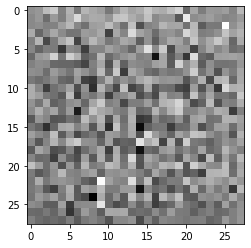

In [5]:
generator = define_generator(100)

noise = tf.random.normal([1, 100])
label = tf.reshape(2, (-1, 1))
generated_image = generator([noise, label], training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [6]:
discriminator = define_discriminator()

desicion = discriminator([generated_image, label], training=False)
print(desicion)

tf.Tensor([[0.4999541]], shape=(1, 1), dtype=float32)


## Define GAN for Training Generator
For the discriminator to train, we only need to real dataset and fake dataset. But for generator to train, we need the fake input(noise and labels) as well as the discriminator.

In [7]:
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	gen_noise, gen_label = g_model.input
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])

	model = models.Model([gen_noise, gen_label], gan_output)

	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [8]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    noise = tf.random.normal([n_samples, latent_dim])
    fake_labels = tf.reshape(tf.random.uniform(shape=(n_samples,), minval=0, maxval=n_classes, dtype=tf.int32), (-1, 1))
    return noise, fake_labels

## Define training function

In [9]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, model_name, latent_dim=100, epochs=50):
	# For local storage
	path = os.path.join('./Results/', model_name)
	Path(path).mkdir(parents=True, exist_ok=True)

	ones = tf.ones((BATCH_SIZE, 1))
	half_ones = tf.ones((HALF_BATCH_SIZE, 1))
	half_zeros = tf.zeros((HALF_BATCH_SIZE, 1))

	for epoch in range(epochs):
		d_loss1, d_loss2, g_loss = 0, 0, 0
		for real_images, real_labels in dataset:
			noise, fake_labels = generate_latent_points(latent_dim, HALF_BATCH_SIZE)
			fake_images = g_model([noise, fake_labels])

			# train d_model to identify real images toward 1
			d_loss1, _ = d_model.train_on_batch([real_images, real_labels], half_ones)
			# train d_model to identify fake images toward 0
			d_loss2, _ = d_model.train_on_batch([fake_images, fake_labels], half_zeros)

			noise, fake_labels = generate_latent_points(latent_dim, BATCH_SIZE)
			# train g_model to make d_model identify fake images toward 1
			g_loss = gan_model.train_on_batch([noise, fake_labels], ones)

		if (epoch + 1) % 5 == 0:
			CGAN_visualise_images(g_model, epoch + 1, seed, path)
			print('>%d, d1=%.3f, d2=%.3f g=%.3f' % (epoch + 1, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save(path + '/' + model_name + '.h5')

In [10]:
def CGAN_visualise_images(g_model, epoch, seed, path):
    labels = tf.reshape([x for _ in range(10) for x in range(10)], (-1, 1))

    predictions = g_model.predict([seed, labels])
    fig = plt.figure(figsize=(10,10))

    for i in range(predictions.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow((predictions[i, :, :, 0] + 1) / 2.0, cmap='gray_r')
        plt.axis('off')

    plt.savefig(path + '/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Start training
If you print the loss during training, all of them should be between 0.5 - 1.0.

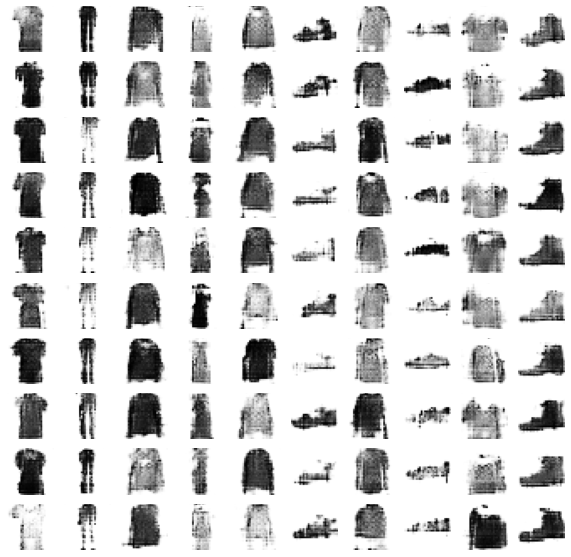

>5, d1=0.695, d2=0.674 g=0.741


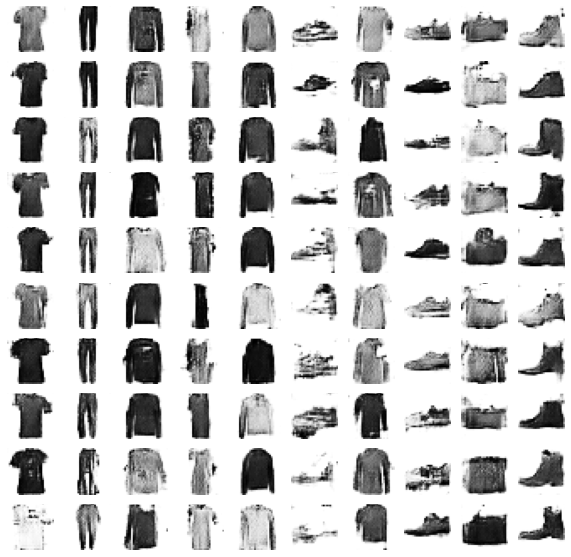

>10, d1=0.657, d2=0.672 g=0.737


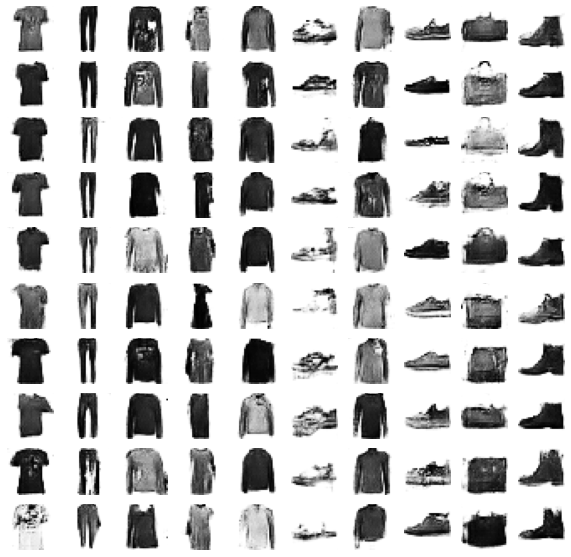

>15, d1=0.671, d2=0.686 g=0.742


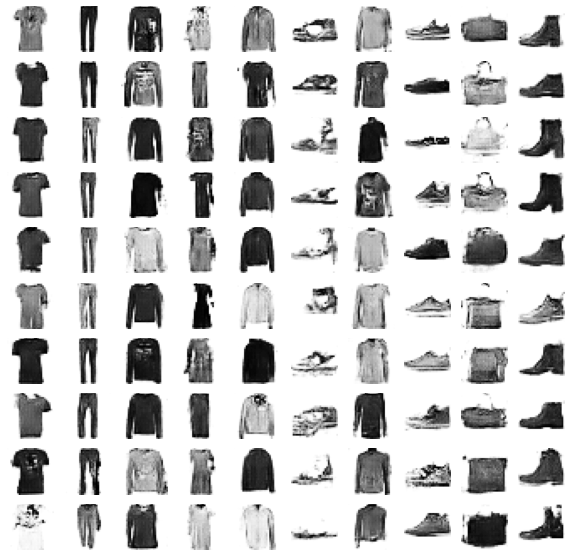

>20, d1=0.674, d2=0.648 g=0.762


In [11]:
EPOCHS = 20
latent_dim = 100
num_examples_to_generate = 100    # for visualise function

seed = tf.random.normal([num_examples_to_generate, latent_dim])    # for visualise the same seed

model_name = 'CGAN_Fashion'    # for saving purpose
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)

# train model
train(g_model, d_model, gan_model, fashion_dataset, model_name, latent_dim, EPOCHS)